# **<span style="color: #8181FF">Simulation to determine the required update frequency</span>**

## **Goal**

We want to test the model's stability over time.<br>
Since we can't predict what data will be added to the dataset in the future, we'll go back in time.<br>
First, we will train the model on the customers of an initial period. Each of these customers will be assigned a cluster label.<br>
We will then re-train the model, successively adding data and watching the evolution of the labels assigned to customers in the initial period..<br>
To compare labels, I'll use the Adjusted Rand Score (ARI).

## Importing Libraries

In [6]:
from google.colab import drive
drive.mount('/content/drive')
import os
drive_folder=  "/content/drive/MyDrive/Colab_Notebooks/Project_5"
os.chdir(drive_folder)
os.listdir()

Mounted at /content/drive


['Liste+de+requetes+SQL+pour+le+dashboard.pdf',
 'olist.db',
 'scripts_sql.sql',
 'requirements.txt',
 'Copie de 01-Analyse_Exploratoire.ipynb',
 'X_tSNE.xlsx',
 'X_tSNE_birch.xlsx',
 'X_tSNE_8_parameters.xlsx',
 'X_tSNE_17_parameters.xlsx',
 'X_tSNE_3_parameters.xlsx',
 'X_tSNE_4_parameters.xlsx',
 'X_tSNE_5_parameters__avg_payment_sequential_avg_review_score.xlsx',
 'Copie de 02-Modélisation.ipynb',
 '03-FRQ~1.ipynb',
 'data_global.xlsx',
 '01-Analyse_Exploratoire.ipynb',
 '02-Modélisation.ipynb',
 '03-Fréquence_de_mise_à_jour.ipynb']

In [8]:
import os
os.listdir()

['Liste+de+requetes+SQL+pour+le+dashboard.pdf',
 'olist.db',
 'scripts_sql.sql',
 'requirements.txt',
 'Copie de 01-Analyse_Exploratoire.ipynb',
 'X_tSNE.xlsx',
 'X_tSNE_birch.xlsx',
 'X_tSNE_8_parameters.xlsx',
 'X_tSNE_17_parameters.xlsx',
 'X_tSNE_3_parameters.xlsx',
 'X_tSNE_4_parameters.xlsx',
 'X_tSNE_5_parameters__avg_payment_sequential_avg_review_score.xlsx',
 'Copie de 02-Modélisation.ipynb',
 '03-FRQ~1.ipynb',
 'data_global.xlsx',
 '01-Analyse_Exploratoire.ipynb',
 '02-Modélisation.ipynb',
 '03-Fréquence_de_mise_à_jour.ipynb']

In [9]:
# Basic libraries
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt

# To normalize and encode data
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Used for clustering model
from sklearn import cluster

# Used to compare clusters
from sklearn.metrics import adjusted_rand_score

# To measure fits and notebook runtimes
import time

- Measuring notebook runtime :

In [10]:
t_notebook = time.time()

## **Dataset import**

In [7]:
data = pd.read_excel("data_global.xlsx")

## **Defining the functions to be used**

- For scaling numerical variables and encoding categorical variables :

In [11]:
def scale_and_encode(features, data, display=True):
    """
    This function scales numerical data and encodes categorical variables while preserving
    column names after transformation.

    - features: list of columns to include
    - data: data used (Pandas DataFrame)
    - Returns a DataFrame with the transformed columns and their updated names.
    """

    # Select numerical variables
    numeric_features = data[features].select_dtypes(include=['number']).columns.tolist()

    # Selection of categorical variables
    categorical_features = data[features].select_dtypes(exclude=['number']).columns.tolist()

    if display:
      print("Standard-scaled numeric features:", numeric_features)
      print("One hot encoded categorical features:", categorical_features)

    # Data selection
    X = data.loc[:, features]

    # Scaler instantiation
    numeric_transformer = StandardScaler()
    # Encoder instantiation
    categorical_transformer = OneHotEncoder(sparse_output=False)

    # Combining transformations
    transformers = []
    if categorical_features:  # Add categorical transformer only if there are categorical features
        transformers.append(('cat', categorical_transformer, categorical_features))
    if numeric_features:  # Add numeric transformer only if there are numeric features
        transformers.append(('num', numeric_transformer, numeric_features))

    feature_encoder = ColumnTransformer(transformers=transformers)

    # Data transformation
    X_transformed = feature_encoder.fit_transform(X)

    # Recovery of transformed column names
    all_column_names = []
    if categorical_features:
        cat_column_names = feature_encoder.named_transformers_['cat'].get_feature_names_out(categorical_features)
        all_column_names.extend(cat_column_names)
    if numeric_features:
        all_column_names.extend(numeric_features)

    # Construction of the final DataFrame with the names
    X_transformed_df = pd.DataFrame(X_transformed, columns=all_column_names, index=data.index)

    return X_transformed_df


- Measuring stability over time :

In [16]:
from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.metrics import adjusted_rand_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def delta_ari(data, features, delta=1, initial_duration=12, clusters=5, display_table=True, n_init=10, model_type='KMeans'):
    """
    This function calculates the Adjusted Rand Index (ARI) score between cluster labels
    determined over the initial period and when new data is added to the initial dataset.

    ARI (between 0 and 1) will compare individuals in common for two clusters models (e.g the first trained on 12 months, the second on 15 months).
    Roughly, the goal is to compare the in-common individuals clusters tags. If they have changed, then que ARI is falling:
    Low ARI scores mean the model has to be retrained.

    delta: Time interval (in months) at which to calculate the comparison.
    initial_duration: Duration (in months) covered by the initial period.
    clusters: Number of clusters to return using the specified clustering model.
    display_table: Whether to show the ARI scores in a table (True/False).
    n_init: Number of initializations for clustering algorithms.
    model_type: Type of clustering model to use ('KMeans' or 'BisectingKMeans').
    """

    # Validate the model_type parameter
    if model_type not in ['KMeans', 'BisectingKMeans']:
        raise ValueError("model_type must be either 'KMeans' or 'BisectingKMeans'.")

    # Select the clustering model class based on the model_type
    if model_type == 'KMeans':
        ClusteringModel = KMeans
    elif model_type == 'BisectingKMeans':
        ClusteringModel = BisectingKMeans

    # Calculate the total period (in months) covered by the dataset
    period_months = (data['first_purchase_date'].max() - data['first_purchase_date'].min()).days / 30.44  # Approx. days/month
    print(f"Total period covered by the dataset: {period_months:.2f} months")
    initial_period = initial_duration
    print(f"Selected duration for the initial period: {initial_period} months.")

    # Number of clusters for the clustering model
    cluster_nb = clusters

    # Create the dataset covering the initial period
    start_date_initial = data['first_purchase_date'].min().replace(day=1)
    end_date_initial = start_date_initial + pd.DateOffset(months=initial_period)
    end_date_initial = end_date_initial.replace(day=pd.to_datetime(end_date_initial).days_in_month)
    data_initial = data[(data['first_purchase_date'] >= start_date_initial) & (data['first_purchase_date'] < end_date_initial)].copy()

    # Recompute recency and frequency variables since we have a new segment
    data_initial['recency'] = (data_initial['last_purchase_date'].max() - data_initial['last_purchase_date']).dt.days
    data_initial['frequency'] = (data_initial['last_purchase_date'].max() - data_initial['first_purchase_date']).dt.days / data_initial['orders_number']

    # Train the model on the initial period
    X_scaled__initial = scale_and_encode(features=features_list, data=data_initial, display=False)
    X_model = X_scaled__initial
    clustering_model = ClusteringModel(
        n_clusters=cluster_nb,
        init='k-means++',
        random_state=19,
        n_init=n_init,
        max_iter=300
    )
    clustering_model.fit(X_model)
    labels_initial = clustering_model.labels_
    data_initial['Initial_Clusters'] = labels_initial

    # Time interval (delta) for adding new data
    delta_chosen = delta
    print("Chosen delta for tracking:", delta_chosen, "months.")

    # ARI scores for each period will be stored in this list
    ari_scores = []

    # First additional period will equal delta_chosen
    period = delta_chosen

    # Train the model for each period and compare labels to the initial period
    # Each new iteration, the model will be trained on data_initial time range + i*delta_chosen until reaching the whole data time range
    # Each iteration prédictions will be compared with
    for i in range(int((period_months - initial_duration) / delta_chosen)):
        # Create the dataset for the new period including the initial period + additional data
        start_date = data['first_purchase_date'].min().replace(day=1)
        end_date = start_date + pd.DateOffset(months=initial_duration) + pd.DateOffset(months=period)
        end_date = end_date.replace(day=pd.to_datetime(end_date).days_in_month)
        data_period = data[(data['first_purchase_date'] >= start_date) & (data['first_purchase_date'] < end_date)].copy()

        # Recompute recency and frequency variables
        data_period['recency'] = (data_period['last_purchase_date'].max() - data_period['last_purchase_date']).dt.days
        data_period['frequency'] = (data_period['last_purchase_date'].max() - data_period['first_purchase_date']).dt.days / data_period['orders_number']

        # Train the model on the current period
        X_scaled_period = scale_and_encode(features=features_list, data=data_period, display=False)
        X_model = X_scaled_period
        clustering_model = ClusteringModel(
            n_clusters=cluster_nb,
            init='k-means++',
            random_state=19,
            n_init=n_init,
            max_iter=300
        )
        clustering_model.fit(X_model)
        labels_period = clustering_model.labels_
        data_period['Period_Clusters'] = labels_period

        # Clusters of initial clients using the initial period data
        a = data_initial['Initial_Clusters']

        # Clusters of initial clients using the data from the current period
        b = data_period.loc[data_period['first_purchase_date'] <= data_initial['first_purchase_date'].max()]['Period_Clusters']

        # Append the calculated ARI score
        ari_scores.append([period, adjusted_rand_score(a, b)])

        # Increment the period for the next iteration
        period += delta_chosen

    # Create a DataFrame with ARI scores for each period
    ari_scores = pd.DataFrame(ari_scores, columns=["Months", "ARI Score"])

    # Optionally display the dataframe of ARI scores
    if display_table:
        display(ari_scores)

    # Plot the ARI scores over time
    fig, ax = plt.subplots(figsize=(12, 8))

    plt.grid(
        True,
        linestyle='--',
        color='gray',
        linewidth=0.5,
    )

    ax.plot(
        ari_scores["Months"],
        ari_scores["ARI Score"],
        marker='o',
        markersize=10,
        linestyle='-',
        color="#8181FF",
        linewidth=3,
    )

    # Set x-axis ticks based on delta_chosen
    ax.set_xticks(range(delta_chosen, period, delta_chosen))
    ax.set_xlim(delta_chosen, period - delta_chosen)

    plt.title(f'\nCluster evolution over time\ncompared to the initial period ({initial_duration} months)\n', fontsize=25)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.set_xlabel("\nMonths\n", fontsize=25)
    ax.set_ylabel("\nARI Scores\n", fontsize=25)

    plt.show()


## RFM Model only

### **Choosing features to use with the model.**

- Choosing features :

In [13]:
features_list = [
    # 'customer_lat',
    # 'customer_lng',
    # 'orders_number',
    # 'first_purchase_date',
    # 'last_purchase_date',
    'recency', # keep this one (RFM)
    'frequency', # keep this one (RFM)
    # 'avg_spent',
    'total_spent', # keep this one (RFM)
    # 'preferred_payment_type',
    # 'avg_payment_sequential',
    # 'avg_payment_installments',
    # 'shipping_fees_proportion',
    # 'avg_customer_seller_distance_km',
    # 'avg_delivery_time',
    # 'preferred_category', # tested : generates noise.
    # 'avg_review_score',
]

### **Model stability over time**

Total period covered by the dataset: 23.42 months
Selected duration for the initial period: 14 months.
Chosen delta for tracking: 1 months.


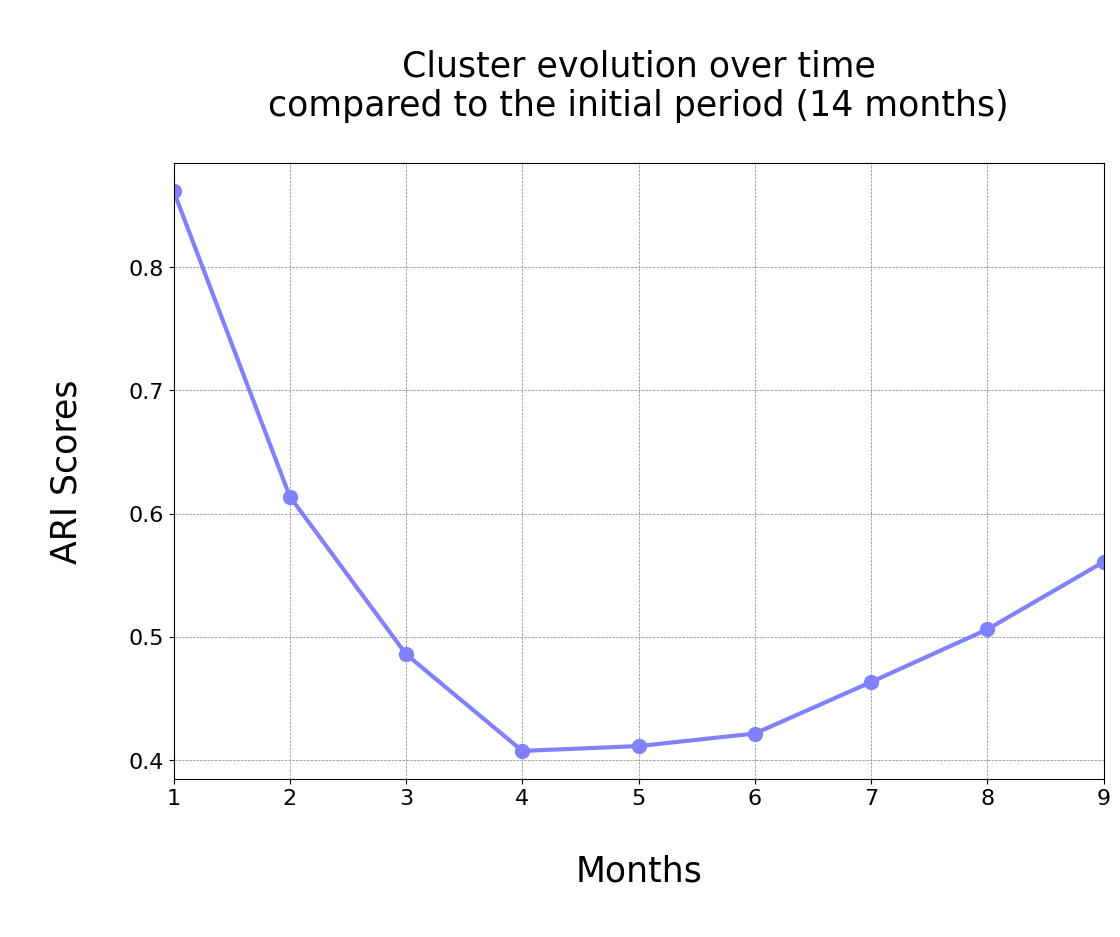

In [17]:
delta_ari(data=data, features=features_list, delta=1, initial_duration=14, clusters=5, display_table=False, n_init=10, model_type='KMeans')

**The ARI score falls fastly. The best thing would be to re-train the model every month. Every 2 months stays acceptable.**

## Advanced Model

### **Choosing features to use with the model.**

- Choosing features :

In [18]:
features_list = [
    # 'customer_lat',
    # 'customer_lng',
    # 'orders_number',
    # 'first_purchase_date',
    # 'last_purchase_date',
    'recency', # keep this one (RFM)
    'frequency', # keep this one (RFM)
    # 'avg_spent',
    'total_spent', # keep this one (RFM)
    # 'preferred_payment_type',
    'avg_payment_sequential',
    # 'avg_payment_installments',
    # 'shipping_fees_proportion',
    # 'avg_customer_seller_distance_km',
    # 'avg_delivery_time',
    # 'preferred_category', # tested : generates noise.
    'avg_review_score',
]

### **Model stability over time**

Total period covered by the dataset: 23.42 months
Selected duration for the initial period: 14 months.
Chosen delta for tracking: 1 months.


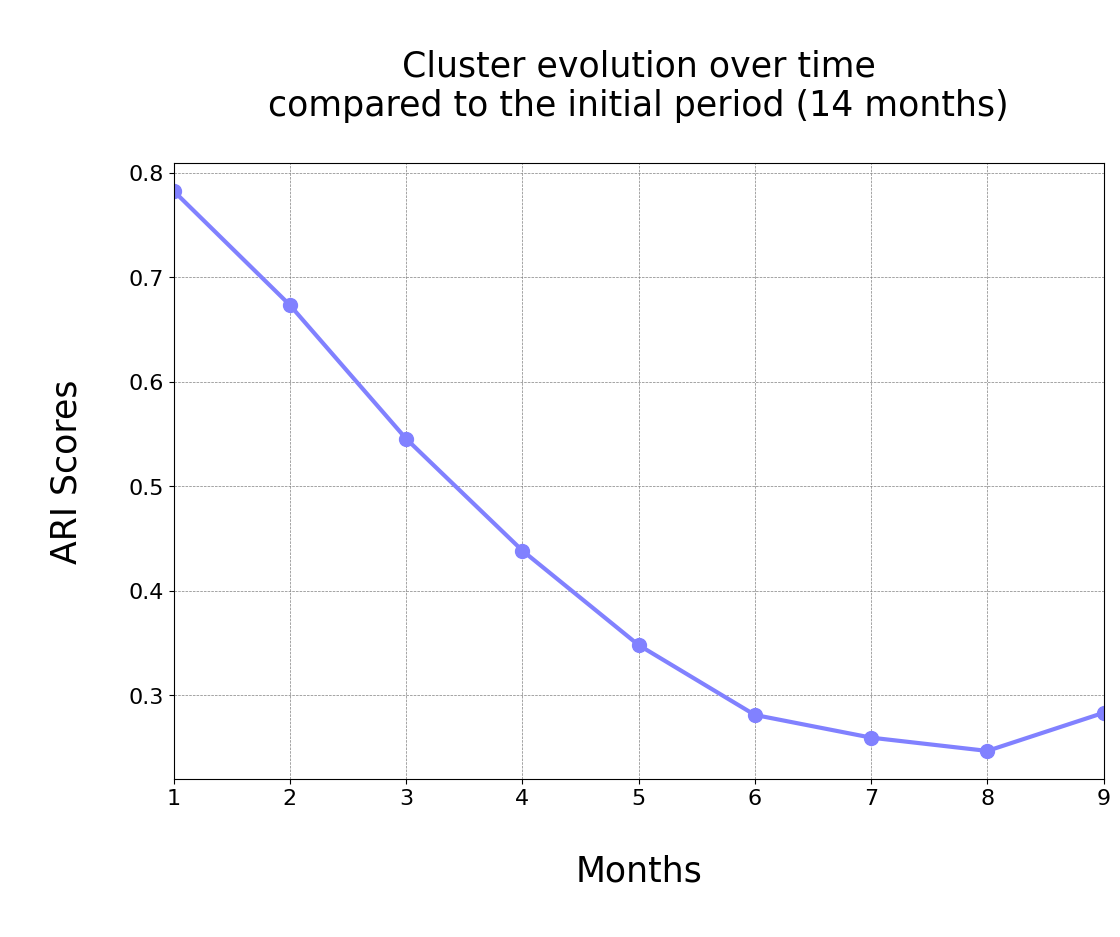

In [19]:
delta_ari(data=data, features=features_list, delta=1, initial_duration=14, clusters=5, display_table=False, n_init=10, model_type='KMeans')

**The ARI score falls fastly. The best thing would be to re-train the model every month. 2 to 3 months can be accepted.**

This model has the best performances and is definitely recommended compared to the standard RFM one.

# Notebook runtime display :

In [ ]:
temps_secondes = time.time() - t_notebook

# Conversion to minutes and seconds
minutes = int(temps_secondes // 60)
seconds = int(temps_secondes % 60)

# Result formatting
formatted_time = f"{minutes:02}:{seconds:02}"

print(f"Notebook runtime (excluding imports): {formatted_time}")

Notebook runtime (excluding imports): 01:15
